# Minimal Operon Detection with polars-bio

This notebook shows a compact pipeline:
- Read GFF with polars-bio
- Merge CDS within `max_gap` to form operon windows
- Overlap CDS back onto windows to assemble operon members
- Optional keyword filtering
- Quick interval visualization


In [ ]:
import polars as pl
import polars_bio as pb
from pathlib import Path
import matplotlib.pyplot as plt

# Locate a demo GFF relative to this notebook
for cand in [Path('data/test.gff'), Path('../data/test.gff'), Path('../../data/test.gff')]:
    if cand.exists():
        GFF_PATH = str(cand)
        break
else:
    raise FileNotFoundError('Set GFF_PATH to your GFF3 file (e.g., data/test.gff)')

MAX_GAP = 50
MIN_GENES = 2
KEYWORDS = ['crispr','cas']
MIN_KEYWORD_HITS = 1
SAME_STRAND_ONLY = True

print('GFF_PATH:', GFF_PATH)

In [17]:
# Load CDS and set interval types expected by polars-bio ops
cds = (
    pb.read_gff(GFF_PATH, attr_fields=['ID','Name','product'])
    .filter(pl.col('type')=='CDS')
    .select(['chrom','strand','start','end','ID','Name','product'])
    .with_columns([pl.col('start').cast(pl.UInt32), pl.col('end').cast(pl.UInt32)])
)
cds

0rows [00:00, ?rows/s]

chrom,strand,start,end,ID,Name,product
str,str,u32,u32,str,str,str
"""chr1""","""+""",100,300,"""cds1""","""geneA""","""CRISPR-associated protein Cas1"""
"""chr1""","""+""",310,500,"""cds2""","""geneB""","""hypothetical protein"""
"""chr1""","""+""",520,700,"""cds3""","""geneC""","""CRISPR repeat-binding protein"""
"""chr1""","""+""",900,1100,"""cds4""","""geneD""","""transposase"""
"""chr1""","""+""",1110,1300,"""cds5""","""geneE""","""Cas3 helicase"""
"""chr1""","""-""",2000,2200,"""cds6""","""geneF""","""regulatory protein"""
"""chr1""","""-""",2210,2400,"""cds7""","""geneG""","""hypothetical protein"""


In [18]:
# polars-bio driven detect_operons: merge + overlap (minimal)
def merged_operon_windows(cds_df: pl.DataFrame, max_gap: int, same_strand_only: bool=True) -> pl.DataFrame:
    parts = []
    if same_strand_only:
        for s in ['+','-']:
            sub = cds_df.filter(pl.col('strand')==s)
            if sub.is_empty():
                continue
            m = pb.merge(sub.select(['chrom','start','end']), min_dist=max_gap, cols=['chrom','start','end'], output_type='polars.DataFrame')
            m = m.with_columns(pl.lit(s).alias('strand'))
            parts.append(m)
    else:
        if not cds_df.is_empty():
            parts.append(pb.merge(cds_df.select(['chrom','start','end']), min_dist=max_gap, cols=['chrom','start','end'], output_type='polars.DataFrame'))
    if not parts:
        return pl.DataFrame()
    merged = pl.concat(parts, how='diagonal_relaxed')
    by = ['chrom'] + (['strand'] if same_strand_only else [])
    merged = merged.sort(by + ['start']).with_columns(pl.int_range(0, pl.len()).over(by).alias('cluster_id'))
    return merged

def detect_operons_pb(cds_df: pl.DataFrame, max_gap: int, min_genes: int, keywords=None, min_keyword_hits: int=0, same_strand_only: bool=True) -> pl.DataFrame:
    merged = merged_operon_windows(cds_df, max_gap=max_gap, same_strand_only=same_strand_only)
    if merged.is_empty():
        return merged
    iv1 = cds_df.select(['chrom','start','end','ID','Name','product'])
    iv2 = merged.select(['chrom','start','end'] + (['strand'] if same_strand_only else []) + ['cluster_id'])
    ov = pb.overlap(iv1, iv2, cols1=['chrom','start','end'], cols2=['chrom','start','end'], suffixes=('_gene','_operon'), output_type='polars.DataFrame')
    toks = sorted(set([k.strip() for k in (keywords or []) if k and k.strip()]))
    patt = '(?i)(' + '|'.join(toks) + ')' if toks else None
    has_kw = pl.lit(False) if not patt else pl.col('product_operon').cast(pl.Utf8).fill_null('').str.contains(patt, literal=False)
    ov = ov.with_columns(has_kw.alias('has_keyword'))
    group_keys = ['chrom_operon'] + (['strand_gene'] if same_strand_only else []) + ['cluster_id_gene']
    ops = ov.group_by(group_keys).agg([
        pl.col('start_operon').min().alias('operon_start'),
        pl.col('end_operon').max().alias('operon_end'),
        pl.len().alias('gene_count'),
        pl.col('ID_operon').implode().alias('member_ids'),
        pl.col('Name_operon').implode().alias('member_names'),
         pl.col('product_operon').implode().alias('member_products'),
        pl.col('has_keyword').sum().alias('keyword_hits'),
    ])
    ops = ops.filter(pl.col('gene_count') >= min_genes)
    if min_keyword_hits > 0:
        ops = ops.filter(pl.col('keyword_hits') >= min_keyword_hits)
    return ops.sort(group_keys[:-1] + ['operon_start'])


In [19]:
# Run detection
ops = detect_operons_pb(cds, MAX_GAP, MIN_GENES, KEYWORDS, MIN_KEYWORD_HITS, SAME_STRAND_ONLY)
# Flatten list columns for compact display
def flatten_lists(df: pl.DataFrame) -> pl.DataFrame:
    lcols = [name for name, dt in df.schema.items() if isinstance(dt, pl.List)]
    return df.with_columns([pl.col(c).list.join('|').alias(c) for c in lcols]) if lcols else df
flatten_lists(ops)

chrom_operon,strand_gene,cluster_id_gene,operon_start,operon_end,gene_count,member_ids,member_names,member_products,keyword_hits
str,str,i64,u32,u32,u32,str,str,str,u32
"""chr1""","""+""",0,100,700,3,"""cds1|cds2|cds3""","""geneA|geneB|geneC""","""CRISPR-associated protein Cas1…",2
"""chr1""","""+""",1,900,1300,2,"""cds4|cds5""","""geneD|geneE""","""transposase|Cas3 helicase""",1


shape: (3, 6)
┌───────┬───────┬──────┬─────────────┬────────┬────────────┐
│ chrom ┆ start ┆ end  ┆ n_intervals ┆ strand ┆ cluster_id │
│ ---   ┆ ---   ┆ ---  ┆ ---         ┆ ---    ┆ ---        │
│ str   ┆ u32   ┆ u32  ┆ i64         ┆ str    ┆ i64        │
╞═══════╪═══════╪══════╪═════════════╪════════╪════════════╡
│ chr1  ┆ 100   ┆ 700  ┆ 3           ┆ +      ┆ 0          │
│ chr1  ┆ 900   ┆ 1300 ┆ 2           ┆ +      ┆ 1          │
│ chr1  ┆ 2000  ┆ 2400 ┆ 2           ┆ -      ┆ 0          │
└───────┴───────┴──────┴─────────────┴────────┴────────────┘


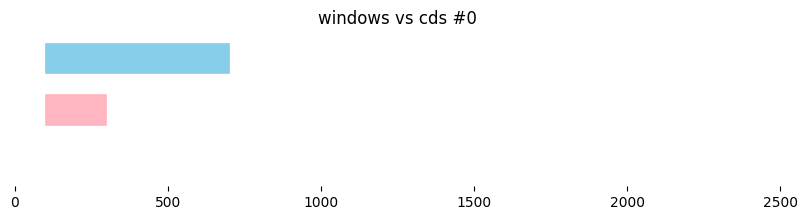

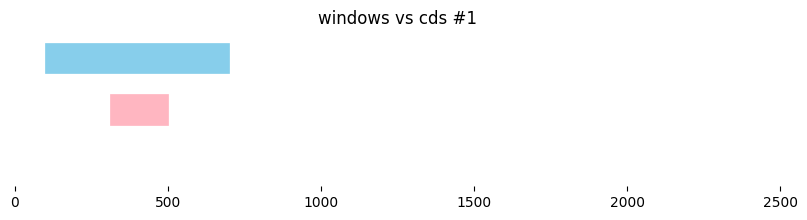

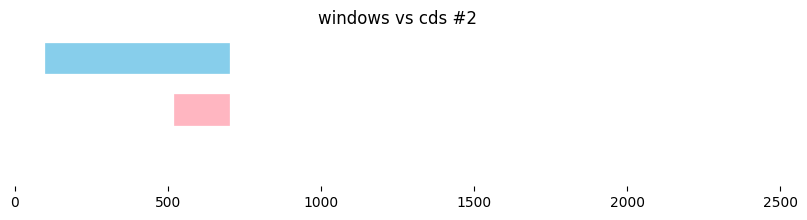

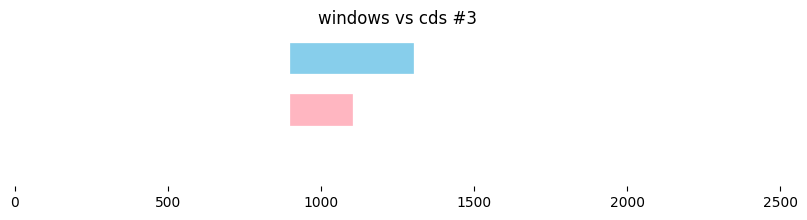

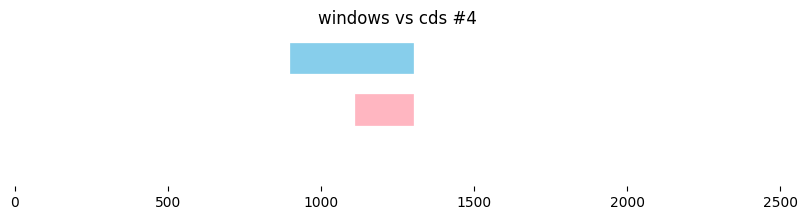

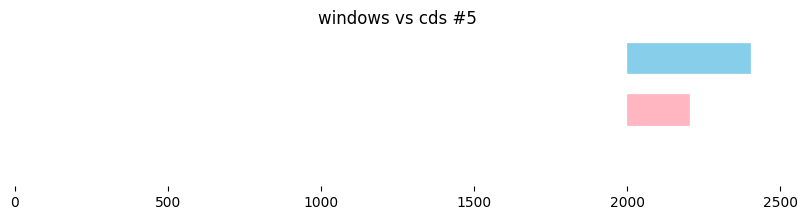

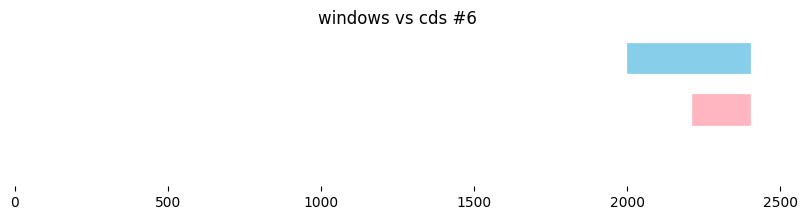

In [ ]:
# Minimal visualization: overlapping windows vs CDS on one contig
win = merged_operon_windows(cds, MAX_GAP, SAME_STRAND_ONLY)
print(win)
if not win.is_empty():
    chrom0 = win['chrom'][0]
    pairs = pb.overlap(
        win.select(['chrom','start','end']),
        cds.select(['chrom','start','end']),
        cols1=['chrom','start','end'],
        cols2=['chrom','start','end'],
        suffixes=('_1','_2'),
        output_type='polars.DataFrame'
    ).filter(pl.col('chrom_1')==chrom0)
    import bioframe as bf
    if not pairs.is_empty():
        xmin = min(*pairs.select([pl.col('start_1').min(), pl.col('start_2').min()]).row(0))
        xmax = max(*pairs.select([pl.col('end_1').max(), pl.col('end_2').max()]).row(0))
        pad = max(1, int(0.05 * (xmax - xmin)))
        for i, reg in pairs.to_pandas().iterrows():
            bf.vis.plot_intervals_arr(
                starts=[reg.start_1, reg.start_2],
                ends=[reg.end_1, reg.end_2],
                colors=['skyblue', 'lightpink'],
                levels=[2, 1],
                xlim=(xmin - pad, xmax + pad),
                show_coords=True,
            )
            ax = plt.gca()
            # Improve visibility: remove dark edges and use normal aspect
            for p in ax.patches:
                p.set_edgecolor(p.get_facecolor())
                p.set_linewidth(0.5)
            ax.set_aspect('auto')
            plt.title(f'windows #{reg}vs cds #{i}')
        plt.show()
    else:
        print('No overlapping windows and CDS on', chrom0)
else:
    print('No merged windows')


In [ ]:
# Real-world data (lazy load from URL with cache)
from typing import Optional
import os, io
from pathlib import Path

REAL_GFF_URL = (
    # NCBI RefSeq: E. coli K-12 substr. MG1655 (GCF_000005845.2)
    'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/'
    'GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.gff.gz'
)
REAL_CACHE = Path('data/real')
REAL_CACHE.mkdir(parents=True, exist_ok=True)

def download_if_missing(url: str, dest_dir: Path = REAL_CACHE) -> Path:
    import requests
    local = dest_dir / Path(url).name
    if local.exists() and local.stat().st_size > 0:
        return local
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(local, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1<<20):
                if chunk:
                    f.write(chunk)
    return local

def scan_gff_cds_lazy(path: str | Path) -> pl.LazyFrame:
    # GFF3 fields
    cols = ['seqid','source','type','start','end','score','strand','phase','attributes']
    lf = pl.scan_csv(
        str(path),
        separator='	',
        has_header=False,
        comment_char='#',
        new_columns=cols,
        dtypes={
            'seqid': pl.Utf8, 'source': pl.Utf8, 'type': pl.Utf8,
            'start': pl.Int64, 'end': pl.Int64, 'score': pl.Utf8,
            'strand': pl.Utf8, 'phase': pl.Utf8, 'attributes': pl.Utf8,
        },
        null_values=['.'],
    )
    # Keep CDS and extract a few attributes
    attr = pl.col('attributes').fill_null('')
    def attr_val(key: str) -> pl.Expr:
        # Match key=VALUE up to next ';' or end
        return attr.str.extract(fr'(?:^|;){key}=([^;]*)', group_index=1)
    return (
        lf.filter(pl.col('type')=='CDS')
          .with_columns([
              pl.col('seqid').alias('chrom'),
              attr_val('ID').alias('ID'),
              attr_val('Name').alias('Name'),
              attr_val('product').alias('product'),
          ])
          .select(['chrom','strand','start','end','ID','Name','product'])
    )

# Download (cached) and build a lazy CDS frame
try:
    real_path = download_if_missing(REAL_GFF_URL)
    cds_real_lf = scan_gff_cds_lazy(real_path)
    cds_real_lf
except Exception as e:
    print('Real data setup skipped:', e)


In [ ]:
# Collect lazily and run detection on real data (streaming collect)
try:
    cds_real = cds_real_lf.collect(streaming=True)
    print('CDS rows (real):', cds_real.height)
    ops_real = detect_operons_pb(cds_real, MAX_GAP, MIN_GENES, KEYWORDS, MIN_KEYWORD_HITS, SAME_STRAND_ONLY)
    flatten_lists(ops_real).head(10)
except NameError:
    print('Real dataset not initialized; run the previous cell.')
except Exception as e:
    print('Detection on real data failed:', e)
